In [1]:
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import statsmodels.stats.api as sms
from scipy.stats import randint, uniform
import statsmodels.api as sm

In [2]:
current_dir = Path().cwd()
project_root = current_dir.parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print("Done")

Done


In [3]:
path = project_root / "data" / "cleaned_house_price_pred.csv"
data = pd.read_csv(str(path))

C:\Users\BIT\AppData\Local\Temp\ipykernel_20188\3028449356.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(str(path))


In [4]:
X = data[['location', 'transaction', 'furnishing', 'Area', 'floor_ratio', 'parking_count', 'view_main_road', 'view_park',
       'view_pool', 'no_special_view', 'balcony_count', 'bathroom_count', 'is_gated_community', 'is_premium_brand', 'society_short']]

y = data["Amount_in_lacs"]

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140519 entries, 0 to 140518
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   location            140519 non-null  object 
 1   transaction         140519 non-null  object 
 2   furnishing          140519 non-null  object 
 3   Area                140519 non-null  float64
 4   floor_ratio         140519 non-null  float64
 5   parking_count       140519 non-null  int64  
 6   view_main_road      140519 non-null  int64  
 7   view_park           140519 non-null  int64  
 8   view_pool           140519 non-null  int64  
 9   no_special_view     140519 non-null  int64  
 10  balcony_count       140519 non-null  int64  
 11  bathroom_count      140519 non-null  int64  
 12  is_gated_community  140519 non-null  int64  
 13  is_premium_brand    140519 non-null  int64  
 14  society_short       140519 non-null  object 
dtypes: float64(2), int64(9), object(4)

In [6]:
X = pd.get_dummies(X, columns=['location', 'transaction', 'furnishing', 'society_short'], drop_first=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [8]:
# Let's quikly check the performance
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=101, n_jobs=-1)

In [9]:
# Train
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [10]:
y_train_pred = rf_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred=y_train_pred, y_true=y_train))
r2_train = r2_score(y_pred=y_train_pred, y_true=y_train)
print(f"RMSE(train) Error: {rmse_train}\nr2_score(train): {r2_train}")

RMSE(train) Error: 16.005709461080553
r2_score(train): 0.9698045180804113


In [11]:
y_test_pred = rf_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred=y_test_pred, y_true=y_test))
r2_test = r2_score(y_pred=y_test_pred, y_true=y_test)
print(f"RMSE(test) Error: {rmse_test}\nr2_score(test): {r2_test}")

RMSE(test) Error: 26.207680029750804
r2_score(test): 0.9188859506313448


In [31]:
# trying different depths
errors = []
errors_std = []
depths = [5,10,15,20,25]
for i in tqdm(range(len(depths))):
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=depths[i], n_jobs=-1)
    scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    # print(f"CV RMSC: {np.sqrt(-scores.mean()):.4f} (+/-) {np.sqrt(scores.std()): .4f}")
    errors.append(np.sqrt(-scores.mean()))
    errors_std.append(np.sqrt(scores.std()))

100%|██████████| 5/5 [13:23<00:00, 160.77s/it]


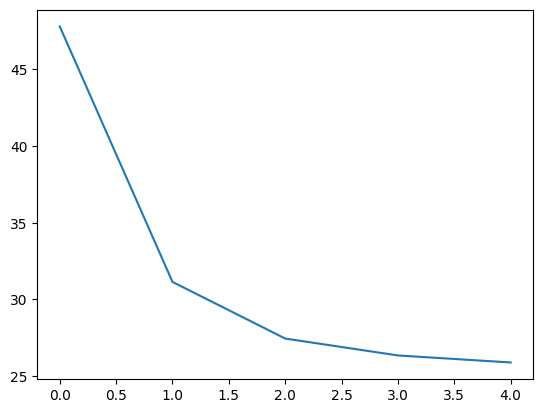

In [32]:
plt.plot(errors);

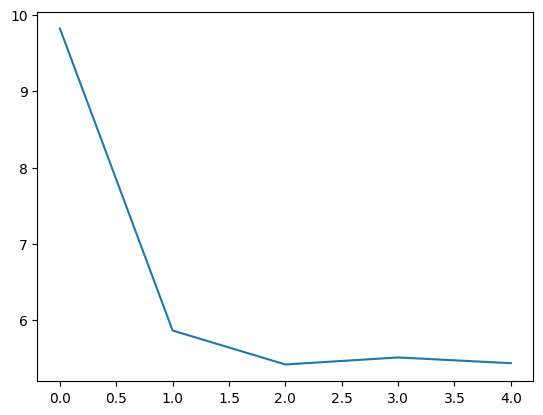

In [33]:
plt.plot(errors_std);

In [36]:
errors

[np.float64(47.80623398639164),
 np.float64(31.14351703094628),
 np.float64(27.448503657313932),
 np.float64(26.345957205486844),
 np.float64(25.88797858889813)]

In [34]:
standard_error = np.array(errors).std()/np.sqrt(5)

In [35]:
standard_error.item()

3.689105799164242

In [12]:
params_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': randint(2, 20),
    'min_samples_split': randint(2, 20),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=params_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'bootstrap': [True, False], 'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_split': <scipy.stats....001DDA5691310>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validat

In [13]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {-random_search.best_score_:.4f}")

Best parameters: {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 406}
Best score: 655.7363


In [14]:
rf_model = RandomForestRegressor(n_estimators=406, max_depth=50, random_state=42, n_jobs=-1, criterion="squared_error", min_samples_split=4, min_samples_leaf=1, max_features="sqrt", bootstrap=False)

In [15]:
rf_model.fit(X=X_train, y=y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",406
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",50
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",4
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [16]:
y_train_pred = rf_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred=y_train_pred, y_true=y_train))
r2_train = r2_score(y_pred=y_train_pred, y_true=y_train)
print(f"RMSE(train) Error: {rmse_train}\nr2_score(train): {r2_train}")

RMSE(train) Error: 7.982746574980232
r2_score(train): 0.9924890167907469


In [17]:
y_test_pred = rf_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred=y_test_pred, y_true=y_test))
r2_test = r2_score(y_pred=y_test_pred, y_true=y_test)
print(f"RMSE(test) Error: {rmse_test}\nr2_score(test): {r2_test}")

RMSE(test) Error: 24.881428915626074
r2_score(test): 0.9268878487399771
